# 7th place solution (0.8502) + late sub (0.4552)

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_log_error
from gensim.models import word2vec
import jpholiday
import swifter
import datetime
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline
from sklearn.decomposition import LatentDirichletAllocation
pd.options.display.max_rows = 1000
import texthero as hero
from texthero import preprocessing as hero_preprocessing
from utils import StratifiedGroupKFold

In [2]:
def read_data():
    train = pd.read_csv('../data/train.csv')
    test = pd.read_csv('../data/test.csv')
    submit = pd.read_csv('../data/atmaCup8_sample-submission.csv')
    
    return train, test, submit

train, test, submit = read_data()
# drop nintendo
train = train[train['Publisher']!='Nintendo'].reset_index(drop=True)
both_exists_developers = list(set(train['Developer'].dropna()) & set(test['Developer'].dropna()))


In [3]:
class Preprocessing:
    def __init__(self):
        self.target_mean_all = {}
        self.hero_pipeline = [hero_preprocessing.fillna
                       , hero_preprocessing.lowercase
                       , hero_preprocessing.remove_digits
                       , hero_preprocessing.remove_punctuation
                       , hero_preprocessing.remove_diacritics
                       , hero_preprocessing.remove_whitespace
                      ]

        
    def target_encoding_train(self, X_train, y_train, col_name, replace=True, target_name=None):
        X_train = X_train.copy()
        y_train = y_train.copy()
        y_train.iloc[:] = np.log1p(y_train)
        
        # テストデータのカテゴリを変換する
        Xy = pd.DataFrame({'trans_col': X_train[col_name], 'target': y_train})
        if self.target_mean_all.get(col_name) is None:
            self.target_mean_all[col_name] = {}
        self.target_mean_all[col_name][target_name] = Xy.groupby('trans_col')['target'].mean()

        # trainを変換する
        oof_target = np.zeros(X_train.shape[0])
        kf = GroupKFold(n_splits=5)
        for idx_1, idx_2 in kf.split(X_train, y_train, self.groups):
            target_mean = Xy.iloc[idx_1, :].groupby('trans_col')['target'].mean()
            oof_target[idx_2] = X_train[col_name].iloc[idx_2].map(target_mean)

        if replace:
            X_train[col_name] = oof_target
        else:
            X_train[f'te_{target_name}_{col_name}'] = oof_target

        return X_train
    
    def target_encoding_test(self, X_test, col_name, replace=True, target_name=None):
        X_test = X_test.copy()
        if replace:
            X_test[col_name] = X_test[col_name].map(self.target_mean_all[col_name][target_name])
        else:
            X_test[f'te_{target_name}_{col_name}'] = X_test[col_name].map(self.target_mean_all[col_name][target_name])
        
        return X_test
    
    def groupby_aggregation(self, df: pd.DataFrame) -> pd.DataFrame:
        columns = df.columns.tolist()
        if 'Critic_Score_pred' in columns:
            for agg_col in tqdm(['Publisher', 'Developer', 'Platform', 'Genre', 'Rating',
                                 'Name_Head_1', 'Name_Head_2', 'Name_Head_3',
                                 'Year_of_Release',
                                 'Bin_Year'
                                ]):
                agg_df = df.groupby([agg_col]).agg(
                    {
                        'Critic_Score_pred': ['mean', 'min', 'max', 'std'],
                        'Critic_Count_pred': ['sum', 'mean', 'min', 'max', 'std'],
                        'User_Score_pred': ['mean', 'min', 'max', 'std'],
                        'User_Count_pred': ['sum', 'mean', 'min', 'max', 'std'],
                    }
                )
                flatten_names = agg_df.columns.to_flat_index().tolist()
                agg_df.columns = [f'{agg_col}_{valname}_{aggname}' for valname, aggname in flatten_names]
                df = df.merge(agg_df, left_on=agg_col, right_index=True, how='left')

                # diff
                for valname in ['Critic_Score_pred', 'Critic_Count_pred', 'User_Score_pred', 'User_Count_pred']:
                    for aggname in ['mean', 'min', 'max']:
                        df[f'Diff_{agg_col}_{valname}_{aggname}'] = df[valname] - df[f'{agg_col}_{valname}_{aggname}']
        
        for agg_col in tqdm(['Publisher', 'Developer', 'Platform', 'Genre', 'Rating',
                             'Name_Head_1', 'Name_Head_2', 'Name_Head_3',
                             'Year_of_Release',
                             'Bin_Year'
                            ] + self.concat_cols):
            if agg_col not in ['Publisher', 'Developer', 'Year_of_Release', 'Bin_Year']:
                agg_df = df.groupby([agg_col]).agg(
                    {
                        'Critic_Score': ['mean', 'min', 'max', 'std'],
                        'Critic_Count': ['sum', 'mean', 'min', 'max', 'std'],
                        'User_Score': ['mean', 'min', 'max', 'std'],
                        'User_Count': ['sum', 'mean', 'min', 'max', 'std'],
                        'Year_of_Release': ['mean', 'min', 'max', 'std']
                    }
                )
            else:
                agg_df = df.groupby([agg_col]).agg(
                    {
                        'Critic_Score': ['mean', 'min', 'max', 'std'],
                        'Critic_Count': ['sum', 'mean', 'min', 'max', 'std'],
                        'User_Score': ['mean', 'min', 'max', 'std'],
                        'User_Count': ['sum', 'mean', 'min', 'max', 'std'],
                    }
                )
            flatten_names = agg_df.columns.to_flat_index().tolist()
            agg_df.columns = [f'{agg_col}_{valname}_{aggname}' for valname, aggname in flatten_names]
            df = df.merge(agg_df, left_on=agg_col, right_index=True, how='left')
            
            # diff
            for valname in ['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']:
                for aggname in ['mean', 'min', 'max']:
                    df[f'Diff_{agg_col}_{valname}_{aggname}'] = df[valname] - df[f'{agg_col}_{valname}_{aggname}']

        # count encoding
        for agg_col in tqdm(['Platform', 'Genre', 'Rating', 'Year_of_Release', 'Bin_Year'] + self.concat_cols):
            count_series = df.groupby(agg_col)['Global_Sales'].count()
            count_series.name = f'ce_{agg_col}'
            df = df.merge(count_series, left_on=agg_col, right_index=True, how='left')
        
        # とっぽさんのやつ
        genre_pivot = df.pivot_table(index='Publisher', columns='Genre', values='Name', aggfunc='count').fillna(0).reset_index()
        plat_pivot = df.pivot_table(index='Publisher', columns='Platform', values='Name', aggfunc='count').fillna(0).reset_index()
        year_pivot = df.pivot_table(index='Publisher', columns='Year_of_Release', values='Name', aggfunc='count').fillna(0).reset_index()
        rating_pivot = df.pivot_table(index='Publisher', columns='Rating', values='Name', aggfunc='count').fillna(0).reset_index()
        pivot_all = genre_pivot.merge(
            plat_pivot, on='Publisher').merge(
            year_pivot, on='Publisher').merge(
            rating_pivot, on='Publisher').set_index('Publisher')
        pivot_scaled = StandardScaler().fit_transform(pivot_all)
        dimension_size = 10
        pca_df = pd.DataFrame(
            PCA(n_components=dimension_size, random_state=0).fit_transform(pivot_scaled),
            columns=[f'publisher_PCA_{i}' for i in range(dimension_size)],
            index=pivot_all.index
        )
        df = df.merge(pca_df, left_on='Publisher', right_index=True, how='left')
        
        # とっぽさんのやつ developerばん
        genre_pivot = df.pivot_table(index='Developer', columns='Genre', values='Name', aggfunc='count').fillna(0).reset_index()
        plat_pivot = df.pivot_table(index='Developer', columns='Platform', values='Name', aggfunc='count').fillna(0).reset_index()
        year_pivot = df.pivot_table(index='Developer', columns='Year_of_Release', values='Name', aggfunc='count').fillna(0).reset_index()
        rating_pivot = df.pivot_table(index='Developer', columns='Rating', values='Name', aggfunc='count').fillna(0).reset_index()
        pivot_all = genre_pivot.merge(
            plat_pivot, on='Developer').merge(
            year_pivot, on='Developer').merge(
            rating_pivot, on='Developer').set_index('Developer')
        pivot_scaled = StandardScaler().fit_transform(pivot_all)
        dimension_size = 10
        pca_df = pd.DataFrame(
            PCA(n_components=dimension_size, random_state=0).fit_transform(pivot_scaled),
            columns=[f'developer_PCA_{i}' for i in range(dimension_size)],
            index=pivot_all.index
        )
        df = df.merge(pca_df, left_on='Developer', right_index=True, how='left')
        
         #cha_kabuさんのやつ
        def get_top_text_ngrams(corpus, n, g , s):
            vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0) 
            words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items() if sum_words[0, idx] > s]
            words_freq =sorted(words_freq, key = lambda x: x[1], reverse=False)
            return words_freq[:n]
#
        clean_name = hero.clean(df['Name'], pipeline=self.hero_pipeline)
#
        most_common_bi = get_top_text_ngrams(clean_name,10000,2,5)
        most_common_bi = dict(most_common_bi)
#
        df["cha_kabu_num_Series_bigram"] = 0
        for i in most_common_bi:
            idx = df[clean_name.str.contains(i)].index
            df.iloc[idx, -1] = most_common_bi[i]
        
        df['Series_Name_bigram'] = np.nan
        for i, name in tqdm(enumerate(clean_name.values)):
            for series_name in most_common_bi:
                if series_name in name:
                    df.iloc[i, -1] = series_name
#
        most_common_bi = get_top_text_ngrams(clean_name,10000,3,5)
        most_common_bi = dict(most_common_bi)
#
        df["cha_kabu_num_Series_trigram"] = 0
        for i in most_common_bi:
            idx = df[clean_name.str.contains(i)].index
            df.iloc[idx, -1] = most_common_bi[i]
        
        df['Series_Name_trigram'] = np.nan
        for i, name in tqdm(enumerate(clean_name.values)):
            for series_name in most_common_bi:
                if series_name in name:
                    df.iloc[i, -1] = series_name
        
        df["cha_kabu_num_Series_bigram"] = df["cha_kabu_num_Series_bigram"] / df.groupby('Series_Name_bigram')['Platform'].transform('nunique')
        df["cha_kabu_num_Series_trigram"] = df["cha_kabu_num_Series_trigram"] / df.groupby('Series_Name_trigram')['Platform'].transform('nunique')
        _groupby = df.groupby('Series_Name_bigram')
        df['cha_kabu_Series_bigram_diff_years'] = _groupby['Year_of_Release'].transform('max') - _groupby['Year_of_Release'].transform('min')
        df['cha_kabu_Series_bigram_elapsed_years'] = df['Year_of_Release'] - _groupby['Year_of_Release'].transform('min')
        _groupby = df.groupby('Series_Name_trigram')
        df['cha_kabu_Series_trigram_diff_years'] = _groupby['Year_of_Release'].transform('max') - _groupby['Year_of_Release'].transform('min')
        df['cha_kabu_Series_trigram_elapsed_years'] = df['Year_of_Release'] - _groupby['Year_of_Release'].transform('min')
        
        self.groups = df['Series_Name_bigram'].values
        
        return df
    
    def execute(self, df: pd.DataFrame, is_train: bool=True, exec_target_encoding=False) -> pd.DataFrame:
        df = df.copy()
        
        # 1st place solution https://www.guruguru.science/competitions/13/discussions/343f21a0-948a-4a73-8899-e37bf25abf9c/
        df_idx = df.index
        df['n'] = 1
        df = df.sort_values(['Genre', 'Year_of_Release'], ascending=False)
        df_idx = df.index
        df = df.reset_index(drop=True)
        df['Genre_serial_num_per'] = df.groupby(['Genre', 'Year_of_Release'])['n'].transform('cumsum')
        summary = df.groupby(['Genre', 'Year_of_Release'])['n'].transform('sum')
        df['Genre_serial_num_per'] = df['Genre_serial_num_per'] / summary
        df.index = df_idx
        df = df.sort_index()
        df = df.sort_values(['Name', 'Year_of_Release'], ascending=False)
        df_idx = df.index
        df = df.reset_index(drop=True)
        df['Name_serial_num_per'] = df.groupby(['Name', 'Year_of_Release'])['n'].transform('cumsum')
        summary = df.groupby(['Name', 'Year_of_Release'])['n'].transform('sum')
        df['Name_serial_num_per'] = df['Genre_serial_num_per'] / summary

        df = df.drop('n', axis=1)
        df.index = df_idx
        df = df.sort_index()
        df['User_Score_is_tbd'] = (df['User_Score'] == 'tbd').astype(int)
        df['User_Score'] = df['User_Score'].apply(lambda x: x if x!='tbd' else np.nan).astype(float)
        # User_ScoreとCritic Scoreの差分
        df['diff_User_Critic_Score'] = df['Critic_Score'] - (df['User_Score'] * 10)
        # User_Score, Critic Scoreを相互にfillnaする
        df['Critic_Score'] = df['Critic_Score'].fillna(df['User_Score'] * 10)
        df['User_Score'] = df['User_Score'].fillna(df['Critic_Score'] / 10)
        df['same_pub_dev'] = (df['Publisher'] == df['Developer']).astype(int)
        df['multi_platform_count'] = df.groupby('Name')['Platform'].transform('nunique')
        
        # UnknownをDeveloperでfillnaする
        df['Publisher'] = df['Publisher'].apply(lambda x: np.nan if x=='Unknown' else x).fillna(df['Developer'])
        
        # cat concat
        self.concat_cols = []
        for left, right in [
            ('Genre', 'Platform'),
            ('Genre', 'Rating'),
            ('Genre', 'Bin_Year'),
            ('Platform', 'Rating'),
            ('Platform', 'Bin_Year'),
            ('Rating', 'Bin_Year')
        ]:
            df[f'{left}_{right}'] = df[left].astype(str).fillna('nan_value') + '_' + df[right].astype(str).fillna('nan_value')
            df[f'{left}_{right}'] = df[f'{left}_{right}'].apply(lambda x: np.nan if x=='nan_value' else x)
            self.concat_cols.append(f'{left}_{right}')
        
        if is_train:
            self.groups = df['Publisher'].values
        
        if exec_target_encoding:
            # target encoding
            encode_cols = ['Platform', 'Genre', 'Developer', 'Rating', 'Bin_Year'] + self.concat_cols
            for encode_col in tqdm(encode_cols):
                if is_train:
                    df = self.target_encoding_train(df, df['Global_Sales'].copy(), encode_col, replace=False, target_name='Global_Sales')
                    df = self.target_encoding_train(df, df['NA_Sales'].copy(), encode_col, replace=False, target_name='NA_Sales')
                    df = self.target_encoding_train(df, df['EU_Sales'].copy(), encode_col, replace=False, target_name='EU_Sales')
                    df = self.target_encoding_train(df, df['JP_Sales'].copy(), encode_col, replace=False, target_name='JP_Sales')
                    df = self.target_encoding_train(df, df['Other_Sales'].copy(), encode_col, replace=False, target_name='other_Sales')
                else:
                    df = self.target_encoding_test(df, encode_col, replace=False, target_name='Global_Sales')
                    df = self.target_encoding_test(df, encode_col, replace=False, target_name='NA_Sales')
                    df = self.target_encoding_test(df, encode_col, replace=False, target_name='EU_Sales')
                    df = self.target_encoding_test(df, encode_col, replace=False, target_name='JP_Sales')
                    df = self.target_encoding_test(df, encode_col, replace=False, target_name='other_Sales')

        
        
        return df
    
    def drop_cols(self, df: pd.DataFrame) -> pd.DataFrame:
        # drop cols
        DROP_COLS = ['Publisher', 'Name',
                     'Name_Head_1', 'Name_Head_2', 'Name_Head_3', 'Developer',
                    'Series_Name_bigram', 'Series_Name_trigram'
                    ]
        df = df.drop(DROP_COLS, axis=1)
        
        return df
    
    def parse_Name_head(self, df: pd.DataFrame) -> pd.DataFrame:
        df['Name_Head_1'] = df['Name'].astype(str).apply(lambda x: x.split()[0])
        df['Name_Head_2'] = df['Name'].astype(str).apply(
                lambda x: x.split()[0] + ' ' +  x.split()[1] if len(x.split()) > 1 else x.split()[0])
        df['Name_Head_3'] = df['Name'].astype(str).apply(
                lambda x: x.split()[0] + ' ' +  x.split()[1] + ' ' +  x.split()[2] if len(x.split()) > 2 else x.split()[0])
        return df

In [4]:
proc = Preprocessing()
len_train = train.shape[0]
train = proc.parse_Name_head(train)
test = proc.parse_Name_head(test)

train_test = pd.concat([train, test], axis=0, ignore_index=True)
train_test['Bin_Year'] = pd.cut(train_test['Year_of_Release'], bins=10, labels=False)
train = train_test.iloc[:len_train, :]
test = train_test.iloc[len_train:, :].reset_index(drop=True)

train = proc.execute(train, exec_target_encoding=True)
test = proc.execute(test, is_train=False, exec_target_encoding=True)

# Developerはtrainとtestどっちにも存在するやつだけteすることにする
for objective in ['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'other_Sales']:
    for i, both_exists in tqdm(enumerate(train['Developer'].isin(both_exists_developers))):
        if both_exists:
            pass
        else:
            train.loc[i, f'te_{objective}_Developer'] = np.nan
    
    for i, both_exists in tqdm(enumerate(test['Developer'].isin(both_exists_developers))):
        if both_exists:
            pass
        else:
            test.loc[i, f'te_{objective}_Developer'] = np.nan

train_test = pd.concat([train, test], axis=0, ignore_index=True)
train_test = proc.groupby_aggregation(train_test)
train = train_test.iloc[:len_train, :]
test = train_test.iloc[len_train:, :].reset_index(drop=True)

In [5]:
def train_lgb(X_train, y_train, X_test, kf, seed=0):
    oof = np.zeros(X_train.shape[0])
    y_pred = np.zeros(X_test.shape[0])
    models = []
        
    for i, (train_index, valid_index) in enumerate(kf):
        print(f'Start {i+1} fold')
        print('-' * 20)
        X_tr, y_tr = X_train.iloc[train_index, :], y_train.iloc[train_index]
        X_val, y_val = X_train.iloc[valid_index, :], y_train.iloc[valid_index]
        X_tes = X_test.copy()

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_valid = lgb.Dataset(X_val, y_val, reference=lgb_train)
        lgb_params = {
            'objective': 'rmse',
            'metric': 'rmse',
            'max_depth': 3,
            'num_leaves': 2 ** 8,
            'learning_rate': 0.01,
            'bagging_fraction': 0.8,
            'feature_fraction': 0.1,
            'random_state': seed,
            'verbosity': -1
            }
        model = lgb.train(
            lgb_params,
            lgb_train,
            valid_sets=(lgb_train, lgb_valid),
            num_boost_round=100000,
            early_stopping_rounds=1000,
            verbose_eval=1000
        )
        oof[valid_index] = model.predict(X_val)
        y_pred += model.predict(X_tes) / 5
        models.append(model)
    
    return oof, y_pred, models

In [6]:
train = proc.drop_cols(train)
test = proc.drop_cols(test)

## Year_of_Releaseをfillnaする

In [7]:
def fillna_prediction(train, test, colname, inplace=True):
    train[f'isna_{colname}'] = train[colname].isna().astype(int)
    test[f'isna_{colname}'] = test[colname].isna().astype(int)
    train_test = pd.concat([train, test], axis=0, ignore_index=True)
    X_train = (
        train_test[train_test[colname].notna()]
            .drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)
    )
    X_tr_idx = X_train.index
    X_train = X_train.reset_index(drop=True)
    y_train = X_train[colname].copy()
    X_train = X_train.drop(colname, axis=1)
    X_test = (
        train_test[train_test[colname].isna()]
            .drop([colname, 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)
    )
    X_tes_idx = X_test.index
    X_test = X_test.reset_index(drop=True)

    CAT_FEATS = ['Platform', 'Genre', 'Rating'] + proc.concat_cols
    X_train.loc[:, CAT_FEATS] = X_train[CAT_FEATS].astype('category')
    X_test.loc[:, CAT_FEATS] = X_test[CAT_FEATS].astype('category')
    oof, y_pred, models = train_lgb(X_train, y_train, X_test, KFold(n_splits=5, shuffle=True, random_state=0).split(X_train))
    if inplace:
        X_train = pd.concat([X_train, y_train], axis=1)
        X_test = pd.concat([X_test, pd.Series(y_pred, name=colname)], axis=1)
        X_train.index = X_tr_idx
        X_test.index = X_tes_idx
        train_test2 = pd.concat([X_train, X_test], axis=0).sort_index()
        print(X_train.shape, X_test.shape, train_test.shape, train_test2.shape)
        train_test2 = pd.concat([train_test2, train_test[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]], axis=1)
        train = train_test2.iloc[:len(train), :]
        test = train_test2.iloc[len(train):, :]
        return train, test
    else:
        train_test2 = pd.concat([train_test, pd.Series(np.concatenate((oof, y_pred)), name=f'{colname}_pred')], axis=1)
        train = train_test2.iloc[:len(train), :]
        test = train_test2.iloc[len(train):, :]
        return train, test

In [8]:
train, test = fillna_prediction(train, test, 'Year_of_Release')
#train, test = fillna_prediction(train, test, 'User_Count', inplace=False)
#train, test = fillna_prediction(train, test, 'Critic_Count', inplace=False)
#train, test = fillna_prediction(train, test, 'User_Score', inplace=False)
#train, test = fillna_prediction(train, test, 'Critic_Score', inplace=False)

Start 1 fold
--------------------


/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 1000 rounds
[1000]	training's rmse: 0.134829	valid_1's rmse: 0.280695
[2000]	training's rmse: 0.0871685	valid_1's rmse: 0.228525
[3000]	training's rmse: 0.0624867	valid_1's rmse: 0.202075
[4000]	training's rmse: 0.0471461	valid_1's rmse: 0.186555
[5000]	training's rmse: 0.037268	valid_1's rmse: 0.176773
[6000]	training's rmse: 0.0309548	valid_1's rmse: 0.170628
[7000]	training's rmse: 0.0267687	valid_1's rmse: 0.166854
[8000]	training's rmse: 0.0238698	valid_1's rmse: 0.164654
[9000]	training's rmse: 0.0215024	valid_1's rmse: 0.163215
[10000]	training's rmse: 0.0195147	valid_1's rmse: 0.162115
[11000]	training's rmse: 0.0177494	valid_1's rmse: 0.16116
[12000]	training's rmse: 0.0163008	valid_1's rmse: 0.160518
[13000]	training's rmse: 0.0150833	valid_1's rmse: 0.160014
[14000]	training's rmse: 0.0140557	valid_1's rmse: 0.159624
[15000]	training's rmse: 0.0131231	valid_1's rmse: 0.159371
[16000]	training's rmse: 0.0123298	valid_1's rmse

[20000]	training's rmse: 0.0104391	valid_1's rmse: 0.04884
[21000]	training's rmse: 0.00998375	valid_1's rmse: 0.048651
[22000]	training's rmse: 0.00952699	valid_1's rmse: 0.0484888
[23000]	training's rmse: 0.00912804	valid_1's rmse: 0.048366
[24000]	training's rmse: 0.00875863	valid_1's rmse: 0.0482604
[25000]	training's rmse: 0.00840826	valid_1's rmse: 0.0481879
[26000]	training's rmse: 0.0081023	valid_1's rmse: 0.0480695
[27000]	training's rmse: 0.00780117	valid_1's rmse: 0.047972
[28000]	training's rmse: 0.00753867	valid_1's rmse: 0.0478821
[29000]	training's rmse: 0.00729216	valid_1's rmse: 0.0478148
[30000]	training's rmse: 0.00706213	valid_1's rmse: 0.0477272
[31000]	training's rmse: 0.00684252	valid_1's rmse: 0.0476594
[32000]	training's rmse: 0.00663579	valid_1's rmse: 0.0476023
[33000]	training's rmse: 0.00644045	valid_1's rmse: 0.047546
[34000]	training's rmse: 0.00626721	valid_1's rmse: 0.0475073
[35000]	training's rmse: 0.00609491	valid_1's rmse: 0.0474696
[36000]	training

In [9]:
train_filled_year = train['Year_of_Release'].astype(int).values
test_filled_year = test['Year_of_Release'].astype(int).values

train, test, submit = read_data()
# drop nintendo
train = train[train['Publisher']!='Nintendo'].reset_index(drop=True)

train['Year_of_Release'] = train_filled_year
test['Year_of_Release'] = test_filled_year

proc = Preprocessing()
len_train = train.shape[0]
train = proc.parse_Name_head(train)
test = proc.parse_Name_head(test)

train_test = pd.concat([train, test], axis=0, ignore_index=True)
train_test['Bin_Year'] = pd.cut(train_test['Year_of_Release'], bins=10, labels=False)
train = train_test.iloc[:len_train, :]
test = train_test.iloc[len_train:, :].reset_index(drop=True)

train = proc.execute(train, exec_target_encoding=True)
test = proc.execute(test, is_train=False, exec_target_encoding=True)

# Developerはtrainとtestどっちにも存在するやつだけteすることにする
for objective in ['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'other_Sales']:
    for i, both_exists in tqdm(enumerate(train['Developer'].isin(both_exists_developers))):
        if both_exists:
            pass
        else:
            train.loc[i, f'te_{objective}_Developer'] = np.nan
    
    for i, both_exists in tqdm(enumerate(test['Developer'].isin(both_exists_developers))):
        if both_exists:
            pass
        else:
            test.loc[i, f'te_{objective}_Developer'] = np.nan

train_test = pd.concat([train, test], axis=0, ignore_index=True)
train_test = proc.groupby_aggregation(train_test)
train = train_test.iloc[:len_train, :]
test = train_test.iloc[len_train:, :].reset_index(drop=True)

train = proc.drop_cols(train)
test = proc.drop_cols(test)

In [10]:
for i, val in enumerate(proc.groups):
    if type(val) != str:
        if np.isnan([val]):
            proc.groups[i] = f'nan_val_{i}'

proc.groups = proc.groups[:len(train)]

In [11]:
joblib.dump((train, test, proc.groups), '../output/features.joblib')

['../output/features.joblib']

In [12]:
train, test, _ = joblib.load('../output/features.joblib')

In [13]:
X_train = train.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)
y_train = np.log1p(train['Global_Sales'])
X_test = test.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1).copy()

In [14]:
CAT_FEATS = ['Platform', 'Genre', 'Rating'] + proc.concat_cols
X_train.loc[:, CAT_FEATS] = X_train[CAT_FEATS].astype('category')
X_test.loc[:, CAT_FEATS] = X_test[CAT_FEATS].astype('category')

In [15]:
stratified_y = pd.cut(y_train, 10, labels=False)

In [16]:
exec_single = True

if exec_single:
    oof, y_pred, models = train_lgb(
        X_train,
        y_train,
        X_test,
        StratifiedGroupKFold(n_splits=5, random_state=0).split(X_train, y=stratified_y, groups=proc.groups)
    )
else:
    # seed averaging
    n = 10
    oofs = np.zeros((len(X_train), n))
    y_preds = np.zeros((len(X_test), n))

    for i in range(n):
        oof, y_pred, models = train_lgb(X_train, y_train, X_test, GroupKFold(n_splits=5).split(X_train, groups=proc.groups), seed=i)
        oofs[:, i] = oof
        y_preds[:, i] = y_pred

    oof = oofs.mean(axis=1)
    y_pred = y_preds.mean(axis=1)

Start 1 fold
--------------------
Training until validation scores don't improve for 1000 rounds


/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[1000]	training's rmse: 0.506283	valid_1's rmse: 0.576925
[2000]	training's rmse: 0.376549	valid_1's rmse: 0.480493
[3000]	training's rmse: 0.319123	valid_1's rmse: 0.44359
[4000]	training's rmse: 0.286741	valid_1's rmse: 0.426166
[5000]	training's rmse: 0.262648	valid_1's rmse: 0.413216
[6000]	training's rmse: 0.245355	valid_1's rmse: 0.406521
[7000]	training's rmse: 0.230619	valid_1's rmse: 0.400529
[8000]	training's rmse: 0.218753	valid_1's rmse: 0.396394
[9000]	training's rmse: 0.208041	valid_1's rmse: 0.393258
[10000]	training's rmse: 0.198357	valid_1's rmse: 0.390473
[11000]	training's rmse: 0.189683	valid_1's rmse: 0.388417
[12000]	training's rmse: 0.181938	valid_1's rmse: 0.386834
[13000]	training's rmse: 0.174635	valid_1's rmse: 0.385355
[14000]	training's rmse: 0.168128	valid_1's rmse: 0.383902
[15000]	training's rmse: 0.162093	valid_1's rmse: 0.382508
[16000]	training's rmse: 0.156534	valid_1's rmse: 0.381435
[17000]	training's rmse: 0.151543	valid_1's rmse: 0.380519
[18000]

[33000]	training's rmse: 0.0958297	valid_1's rmse: 0.411498
[34000]	training's rmse: 0.0936262	valid_1's rmse: 0.411264
[35000]	training's rmse: 0.0916387	valid_1's rmse: 0.411232
[36000]	training's rmse: 0.0895695	valid_1's rmse: 0.411015
[37000]	training's rmse: 0.0877817	valid_1's rmse: 0.410929
[38000]	training's rmse: 0.0859051	valid_1's rmse: 0.4108
[39000]	training's rmse: 0.0841517	valid_1's rmse: 0.410672
[40000]	training's rmse: 0.0825617	valid_1's rmse: 0.410535
[41000]	training's rmse: 0.0809431	valid_1's rmse: 0.410433
[42000]	training's rmse: 0.0793239	valid_1's rmse: 0.410367
[43000]	training's rmse: 0.0778284	valid_1's rmse: 0.410234
[44000]	training's rmse: 0.0763442	valid_1's rmse: 0.410229
[45000]	training's rmse: 0.0749449	valid_1's rmse: 0.410184
[46000]	training's rmse: 0.0736356	valid_1's rmse: 0.410075
[47000]	training's rmse: 0.0723646	valid_1's rmse: 0.410023
[48000]	training's rmse: 0.0711198	valid_1's rmse: 0.409989
[49000]	training's rmse: 0.0698808	valid_1

In [17]:
oof = np.where(oof < 0, 0, oof)
y_pred = np.where(y_pred < 0, 0, y_pred)

y_train = np.expm1(y_train)
oof = np.expm1(oof)
y_pred = np.expm1(y_pred)

In [18]:
print(mean_squared_log_error(y_train, oof) ** .5)

0.3850219989479078


In [19]:
submit['Global_Sales'] = y_pred
submit.to_csv('../output/20201214_latesub.csv', index=False)

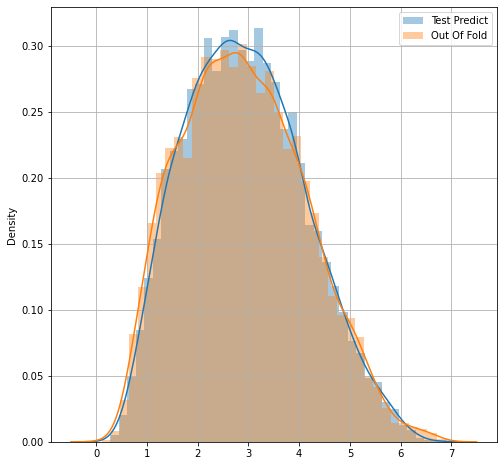

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
#sns.distplot(np.log1p(y_train), label='Ground Truth')
sns.distplot(np.log1p(y_pred), label='Test Predict')
sns.distplot(np.log1p(oof), label='Out Of Fold')
ax.legend()
ax.grid()

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='feature_importance', ylabel='column'>)

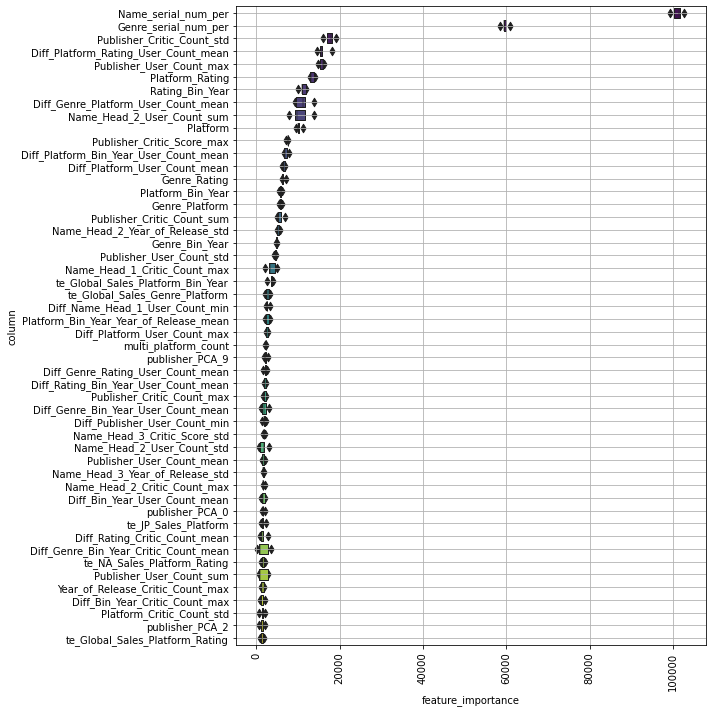

In [21]:
def visualize_importance(models, X_train):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = X_train.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(10, max(6, len(order) * .2)))
    sns.boxenplot(
        data=feature_importance_df,
        y='column',
        x='feature_importance',
        order=order,
        ax=ax,
        palette='viridis',
        orient='h'
    )
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

visualize_importance(models, X_train)

In [22]:
joblib.dump((oof, y_pred), '../output/LGB_oof_ypred.joblib')

['../output/LGB_oof_ypred.joblib']